In [55]:
# Modified from Tutorial:
# https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

import sys
# !{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# Modified for Shakespeare -- first the expected, then a few more that seem to be confusing the model
#stop_words.extend(['from', 'thou', 'thy', 'shall'])
stop_words.extend(['would','from', 'thou', 'thy', 'shall','good','doth','come','make','sir','man'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [56]:
# Import Dataset -- Shakespeare

# Pull all into "data" = all Shakespeare raw text

# directory containing all source texts for training the model 
data_dir="/Users/tharsen/Desktop/populism-rcc-hackathon/corpus/"

import glob, os
os.chdir(data_dir)

#documents = list()
data = list()   # reset data to 0

for filename in glob.glob("*.txt"):
    filedata = open(filename, 'r').read()
    print(filename + " = " + str(len(filedata)) + " chars")
    #documents = documents + filedata.split(".")
    data.append(filedata)


1H4.txt = 130423 chars
1H6.txt = 116317 chars
2H4.txt = 141574 chars
2H6.txt = 135863 chars
3H6.txt = 129551 chars
Ado.txt = 111116 chars
Ant.txt = 133668 chars
AWW.txt = 121896 chars
AYL.txt = 114429 chars
Cor.txt = 146443 chars
Cym.txt = 147159 chars
Err.txt = 76924 chars
H5.txt = 141819 chars
H8.txt = 128223 chars
Ham.txt = 163429 chars
JC.txt = 104561 chars
Jn.txt = 112414 chars
LLL.txt = 115391 chars
Lr.txt = 140510 chars
Luc.txt = 86177 chars
Mac.txt = 91625 chars
MM.txt = 116348 chars
MND.txt = 88608 chars
MV.txt = 112334 chars
Oth.txt = 141395 chars
Per.txt = 97471 chars
PhT.txt = 2072 chars
R2.txt = 120934 chars
R3.txt = 156881 chars
Rom.txt = 130885 chars
Shr.txt = 111364 chars
Son.txt = 97204 chars
TGV.txt = 91686 chars
Tim.txt = 98749 chars
Tit.txt = 109892 chars
Tmp.txt = 88800 chars
TN.txt = 104476 chars
TNK.txt = 127691 chars
Tro.txt = 142635 chars
Ven.txt = 55527 chars
Wiv.txt = 115202 chars
WT.txt = 134528 chars


In [57]:
def sent_to_words(sentences):
    for sent in sentences:
        #sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        #sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
#data = df.content.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])


[['so', 'shaken', 'as', 'we', 'are', 'so', 'wan', 'with', 'care', 'find', 'we', 'time', 'for', 'frighted', 'peace', 'to', 'pant', 'and', 'breathe', 'short', 'winded', 'accents', 'of', 'new', 'broils', 'to', 'be', 'commenced', 'in', 'strands', 'afar', 'remote', 'no', 'more', 'the', 'thirsty', 'entrance', 'of', 'this', 'soil', 'shall', 'daub', 'her', 'lips', 'with', 'her', 'own', 'children', 'blood', 'no', 'more', 'shall', 'trenching', 'war', 'channel', 'her', 'fields', 'nor', 'bruise', 'her', 'flow', 'rets', 'with', 'the', 'armed', 'hoofs', 'of', 'hostile', 'paces', 'those', 'opposed', 'eyes', 'which', 'like', 'the', 'meteors', 'of', 'troubled', 'heaven', 'all', 'of', 'one', 'nature', 'of', 'one', 'substance', 'bred', 'did', 'lately', 'meet', 'in', 'the', 'intestine', 'shock', 'and', 'furious', 'close', 'of', 'civil', 'butchery', 'shall', 'now', 'in', 'mutual', 'well', 'beseeming', 'ranks', 'march', 'all', 'one', 'way', 'and', 'be', 'no', 'more', 'opposed', 'against', 'acquaintance', 'k

In [58]:
%%time

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!
print('\n')



CPU times: user 1min 16s, sys: 11.7 s, total: 1min 28s
Wall time: 48.8 s


In [59]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

### Once again, these settings are crucial to how your model will function. -j ###

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.013*"go" + 0.009*"say" + 0.008*"well" + 0.008*"let" + 0.007*"know" + '
  '0.007*"see" + 0.007*"tell" + 0.007*"hath" + 0.006*"wife" + 0.006*"give"'),
 (1,
  '0.013*"lord" + 0.012*"king" + 0.005*"hath" + 0.005*"let" + 0.004*"death" + '
  '0.004*"hand" + 0.004*"son" + 0.004*"france" + 0.004*"may" + 0.004*"day"'),
 (2,
  '0.034*"caesar" + 0.018*"antony" + 0.014*"brutus" + 0.008*"cassius" + '
  '0.006*"cleopatra" + 0.004*"mark_antony" + 0.003*"egypt" + 0.002*"charmian" '
  '+ 0.002*"casca" + 0.002*"octavius"'),
 (3,
  '0.009*"love" + 0.008*"know" + 0.008*"lord" + 0.007*"say" + 0.007*"go" + '
  '0.007*"may" + 0.007*"see" + 0.007*"let" + 0.005*"give" + 0.005*"take"')]


In [60]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
#df_dominant_topic.head(10)
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.4858,"love, know, lord, say, go, may, see, let, give, take","[shake, wan, care, find, time, fright, peace, pant, breathe, short, wind, accent, new, broil, co..."
1,1,1.0,0.6951,"lord, king, hath, let, death, hand, son, france, may, day","[hang, heaven, black, yield, day, night, comet, import, change, time, state, brandish, crystal, ..."
2,2,3.0,0.5349,"love, know, lord, say, go, may, see, let, give, take","[open, ear, stop, vent, hear, loud, rumor, speak, orient, drooping, west, wind, post, horse, sti..."
3,3,1.0,0.6627,"lord, king, hath, let, death, hand, son, france, may, day","[high, imperial, majesty, charge, depart, france, procurator, excellence, marry, princess, marga..."
4,4,1.0,0.7327,"lord, king, hath, let, death, hand, son, france, may, day","[wonder, king, escape, hand, pursue, horseman, north, slyly, steal, away, left, whereat, great, ..."
5,5,3.0,0.9552,"love, know, lord, say, go, may, see, let, give, take","[learn, letter, pedro, aragon, night, messina, league, leave, many, gentleman, lose, action, sor..."
6,6,3.0,0.8775,"love, know, lord, say, go, may, see, let, give, take","[dotage, general, erflow, measure, goodly, eye, file, muster, war, glow, plated, mar, bend, turn..."
7,7,3.0,0.9637,"love, know, lord, say, go, may, see, let, give, take","[deliver, son, bury, second, husband, go, madam, weep, father, death, anew, must, attend, majest..."
8,8,3.0,0.9632,"love, know, lord, say, go, may, see, let, give, take","[remember, adam, fashion, bequeath, poor, thousand_crown, sayst, charge, brother, blessing, bree..."
9,9,3.0,0.9999,"love, know, lord, say, go, may, see, let, give, take","[proceed, hear, speak, speak, speak, resolve, rather, die, famish, resolve, resolve, first, know..."


In [61]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
#sent_topics_sorteddf_mallet.head(10)
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9999,"go, say, well, let, know, see, tell, hath, wife, give","[hugh, persuade, star, chamber, matter, john, falstaff, abuse, robert_shallow, esquire, county, ..."
1,1.0,0.7327,"lord, king, hath, let, death, hand, son, france, may, day","[wonder, king, escape, hand, pursue, horseman, north, slyly, steal, away, left, whereat, great, ..."
2,3.0,0.9999,"love, know, lord, say, go, may, see, let, give, take","[new, play, maidenhead, akin, much, follow, much, money, giv, stand, sound, well, play, whose, m..."


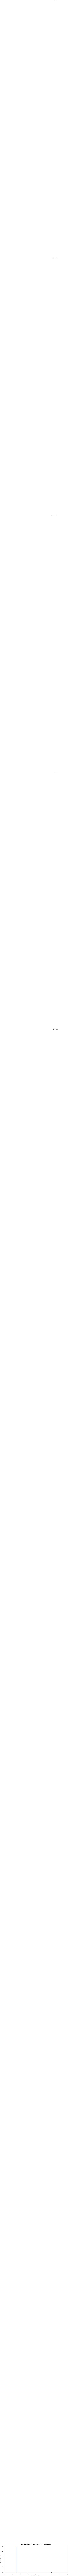

In [64]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=60)  #160
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/Users/tharsen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/Users/tharsen/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/tharsen/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/tharsen/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/bandwidths.py:20: RuntimeWarning: invalid value encountered in minimum
  return np.minimum(np.std(X, axis=0, ddof=1), IQR)
/Users/tharsen/anaconda3/lib/python3.6/site-pa

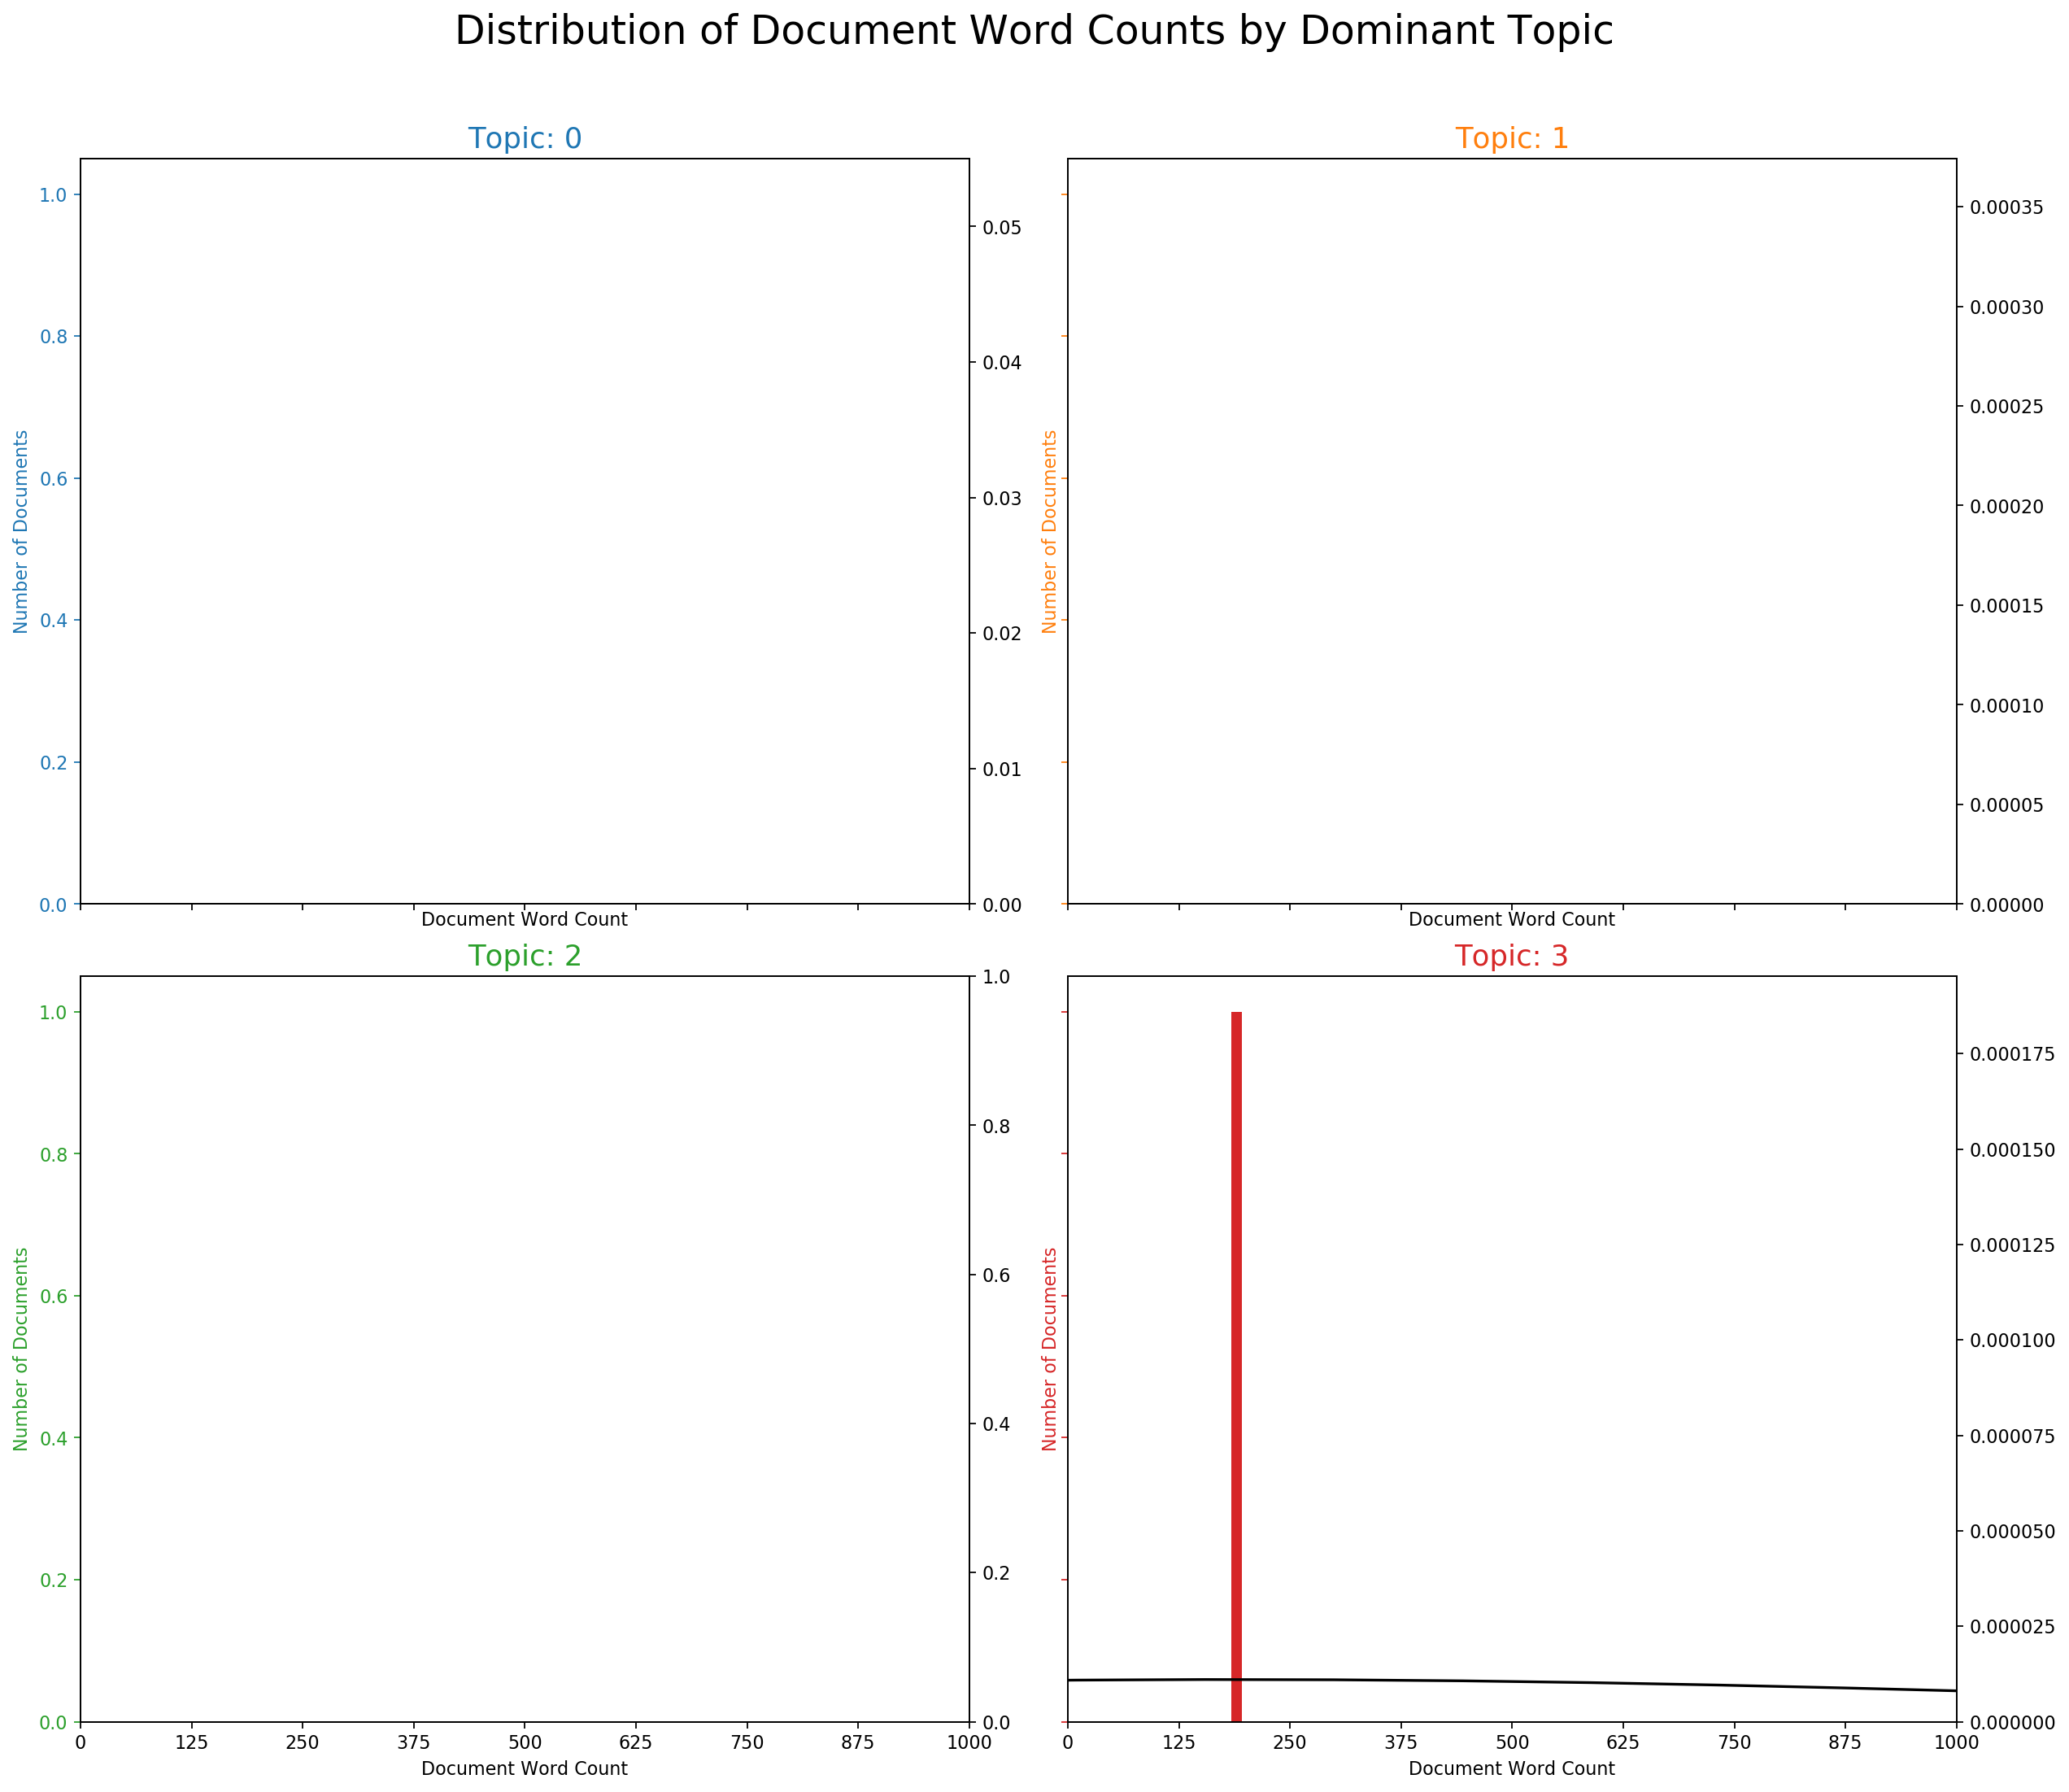

In [65]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

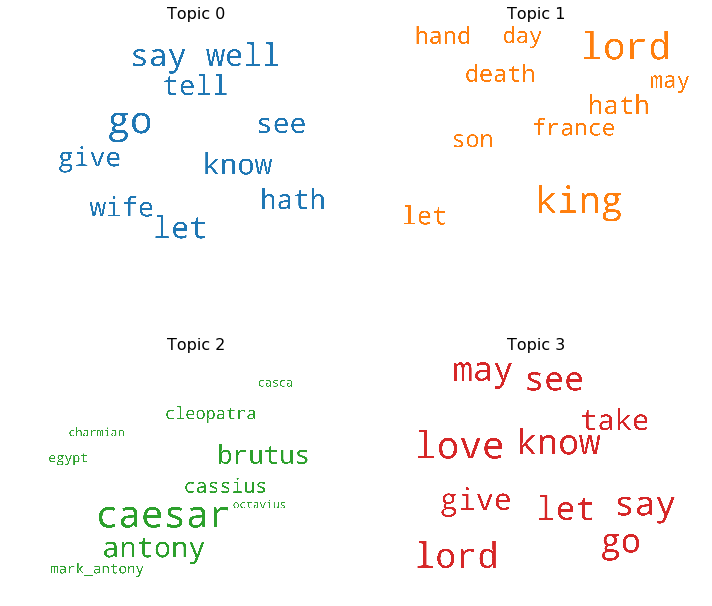

In [66]:
# 1. Wordcloud of Top N words in each topic  -- pip install wordcloud first if you get an error
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True) # 5 = 2

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

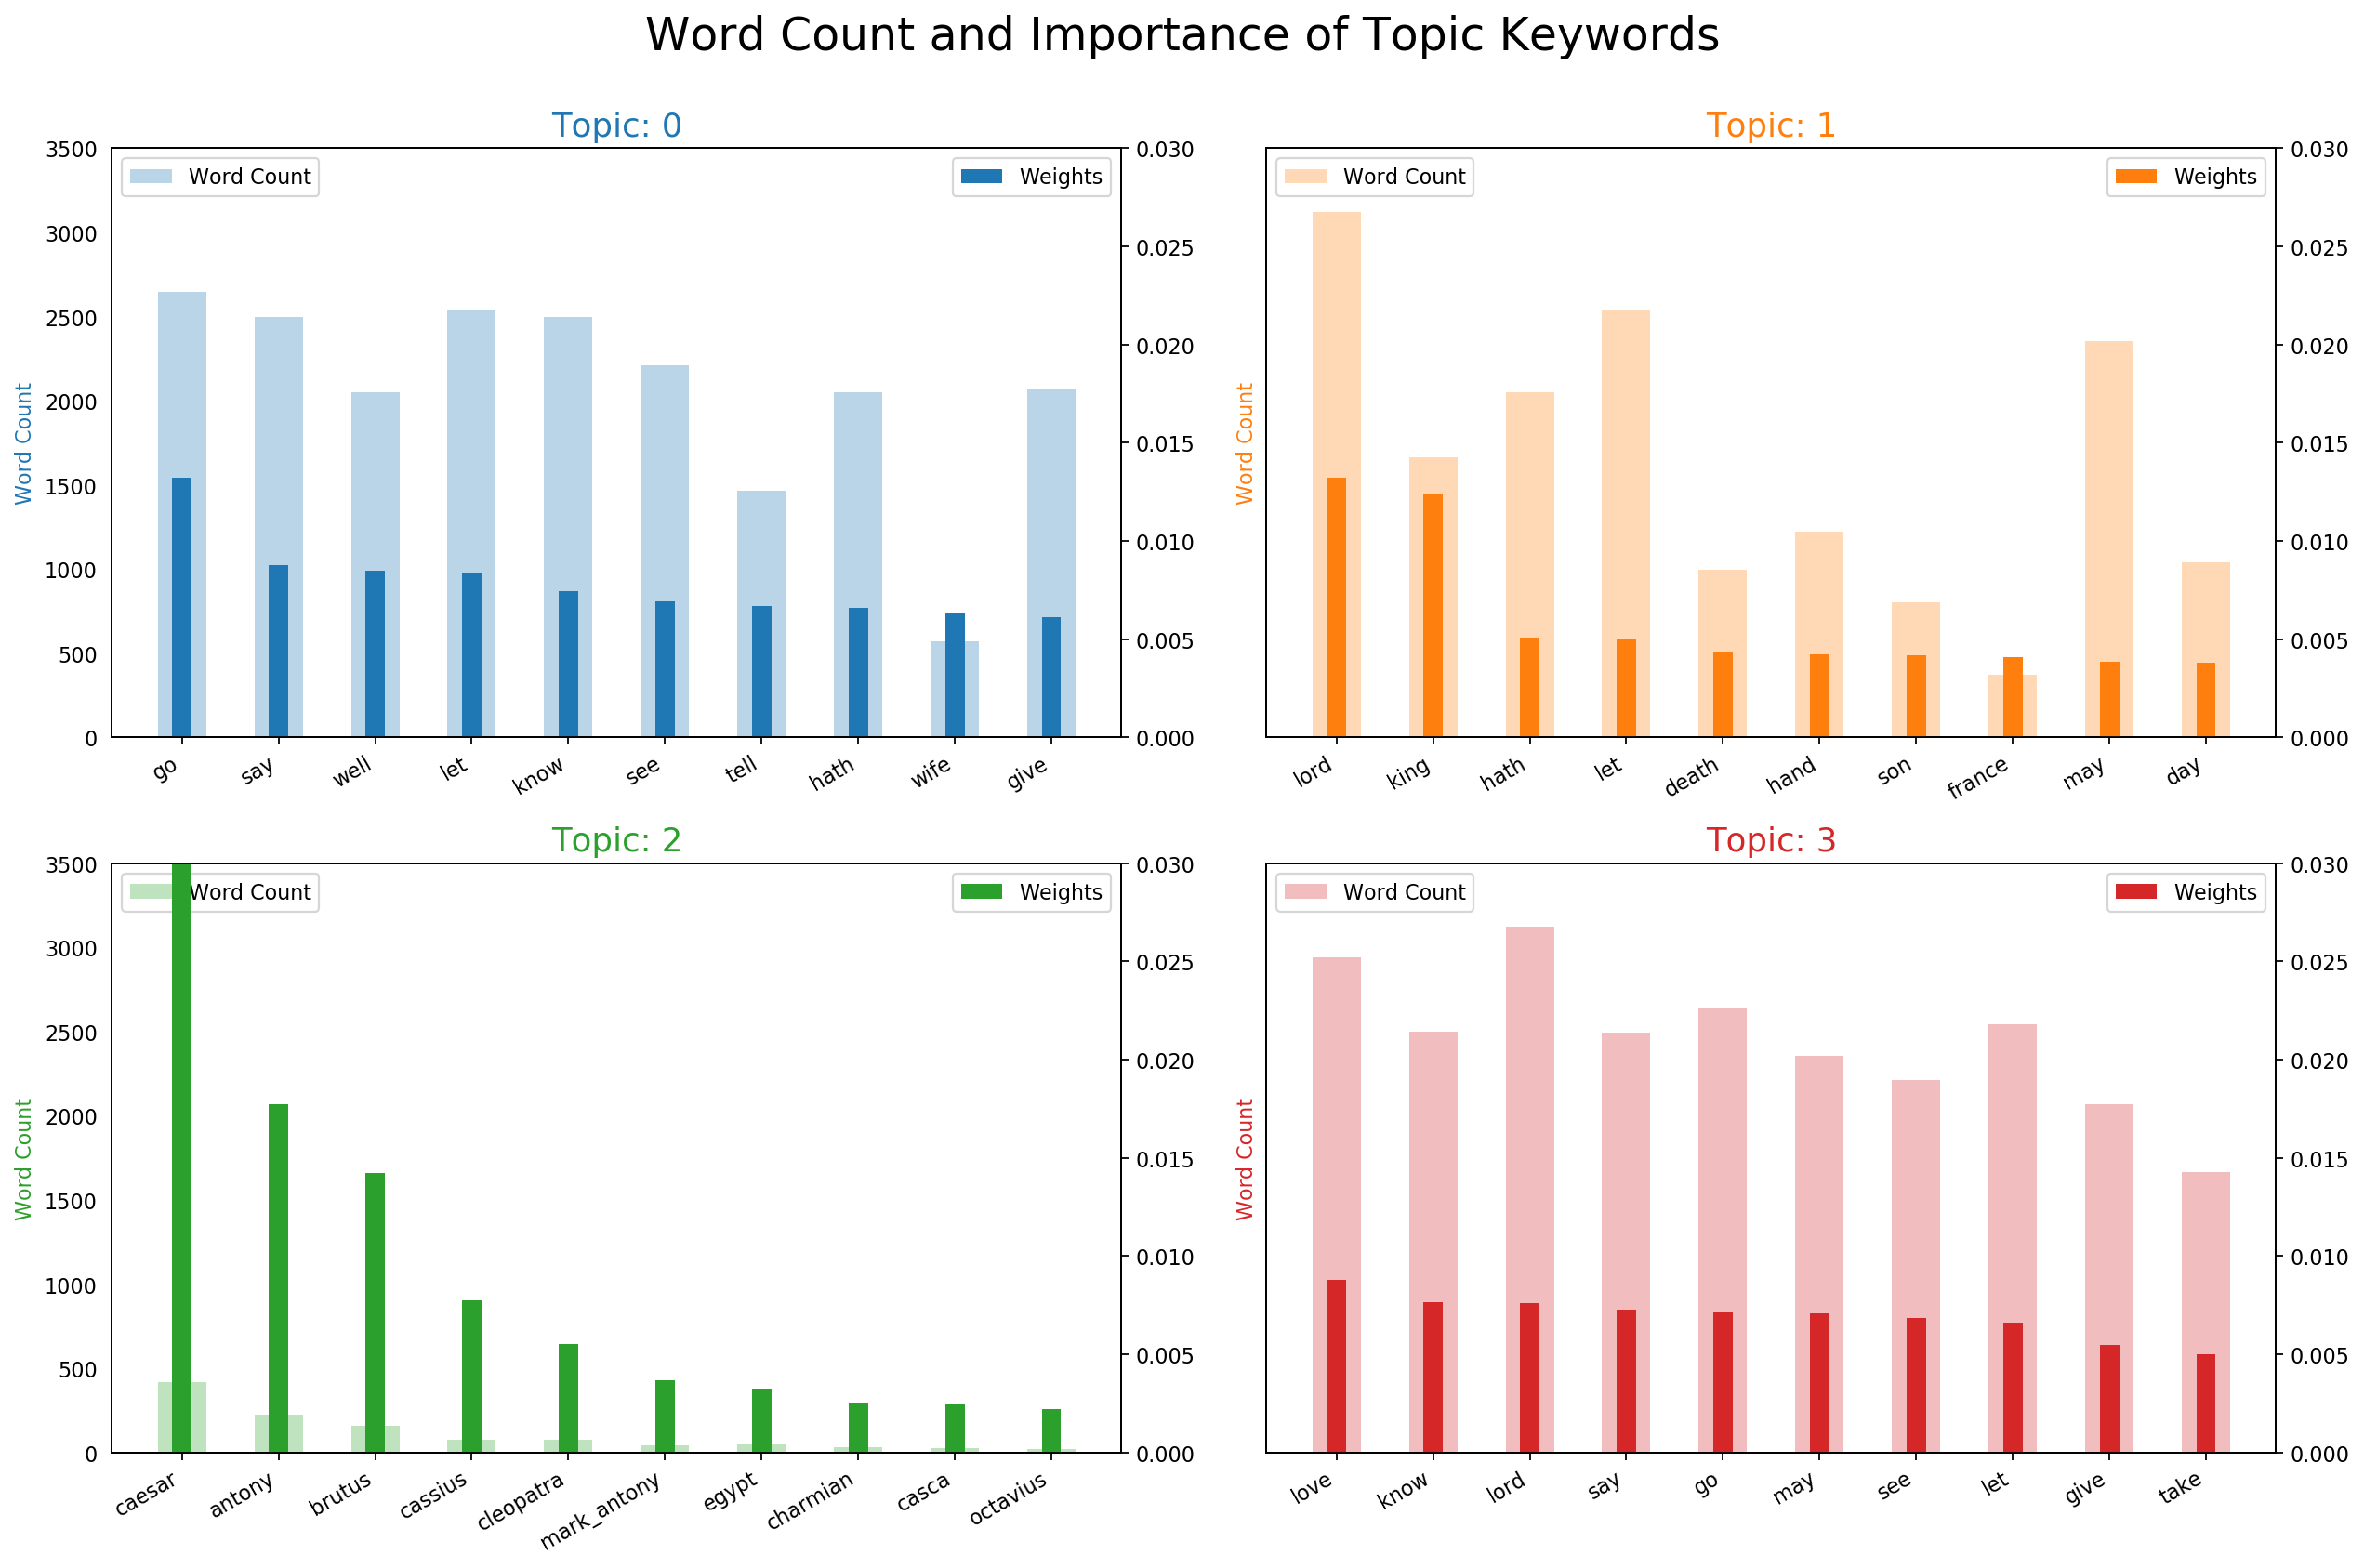

In [67]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

IndexError: list index out of range

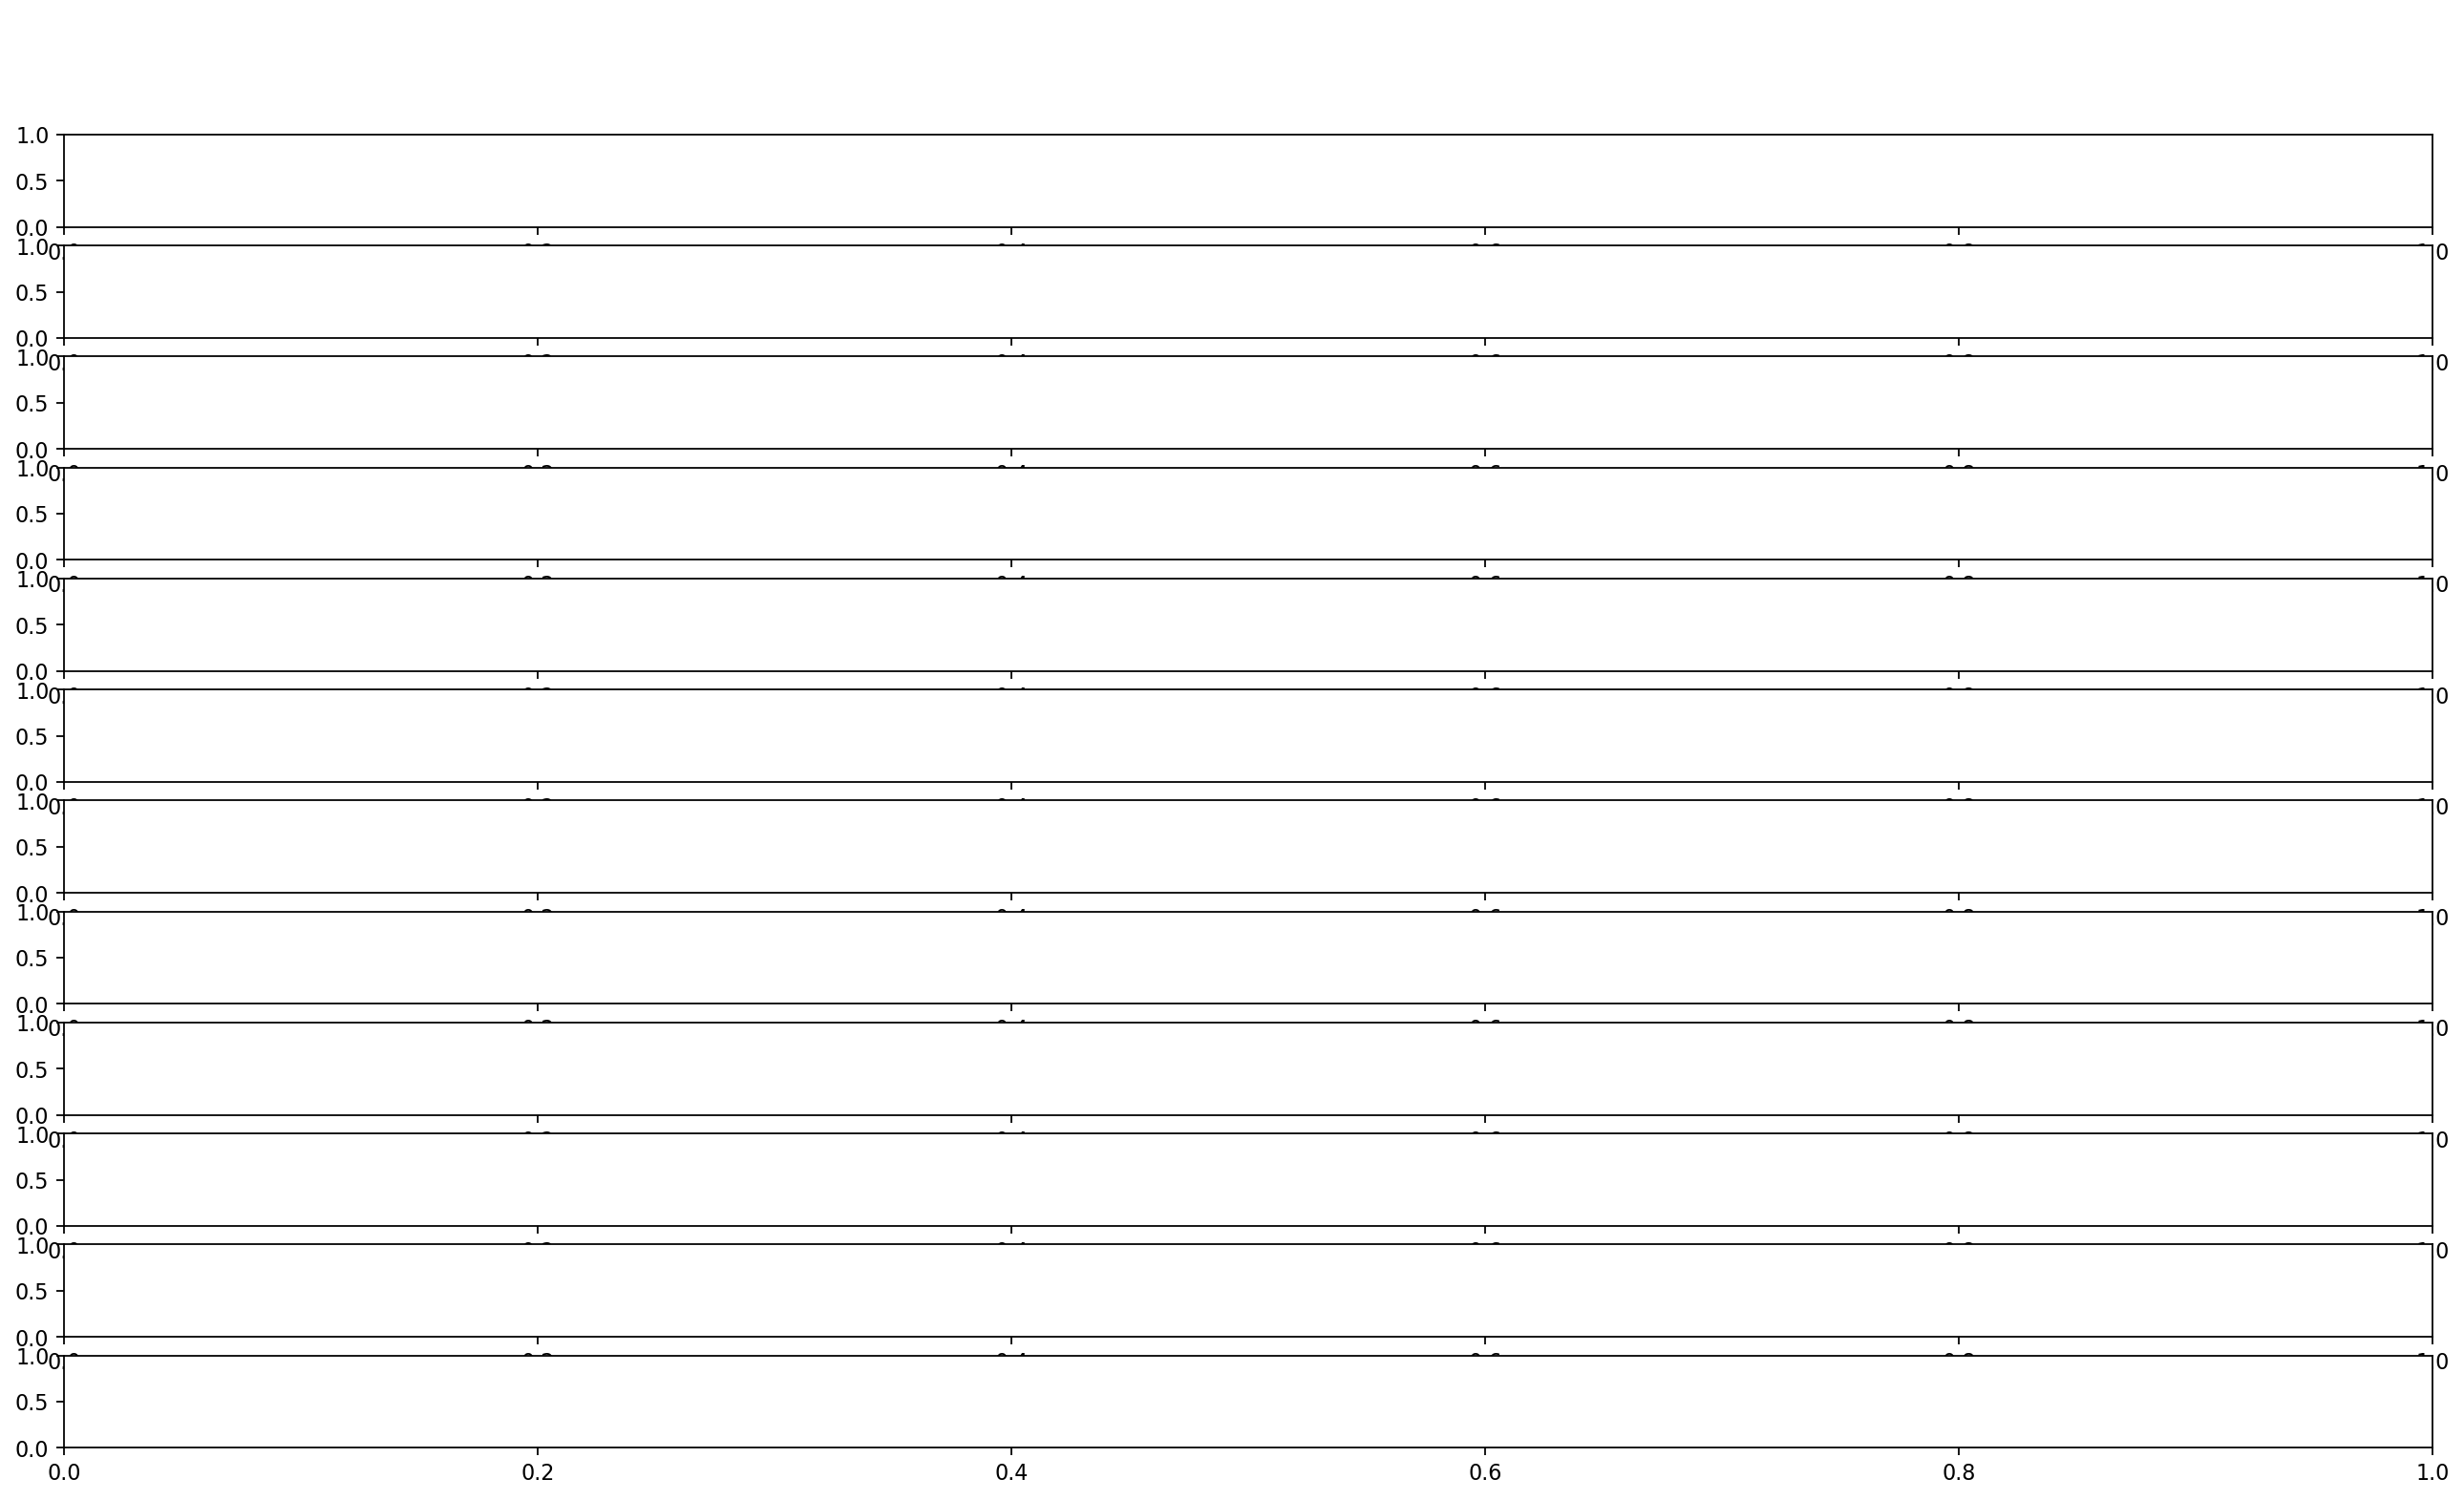

In [28]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [68]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

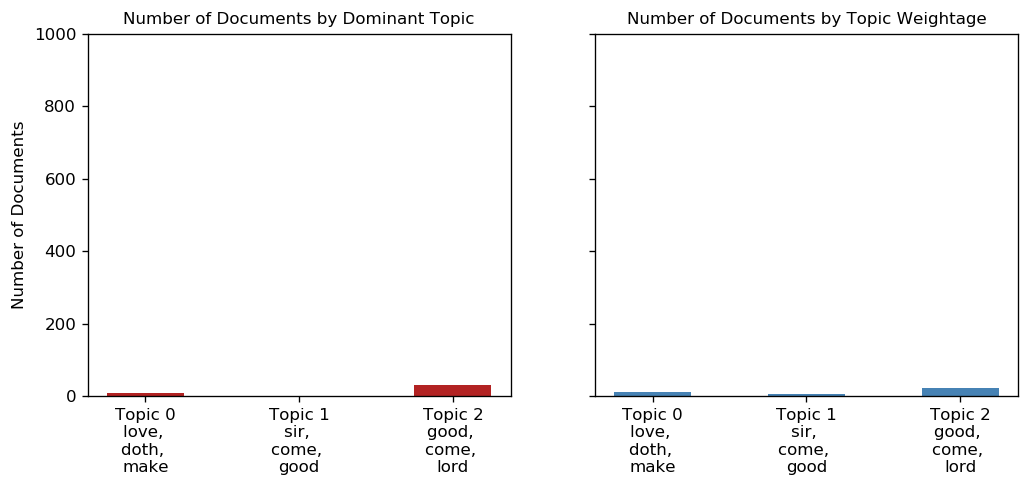

In [43]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [69]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 41 nearest neighbors...
[t-SNE] Indexed 42 samples in 0.000s...
[t-SNE] Computed neighbors for 42 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 42 / 42
[t-SNE] Mean sigma: 0.726311
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.061581
[t-SNE] Error after 950 iterations: 0.397020


Loading BokehJS ...

In [31]:
#show(plot)

In [70]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      75.626846        1       1  0.112092  0.048731
1      17.252995        1       2  0.008267  0.118273
0       6.508815        1       3  0.150043 -0.122723
2       0.611349        1       4 -0.270403 -0.044281, topic_info=      Category         Freq             Term        Total  loglift  logprob
term                                                                       
1088   Default  2552.000000               go  2552.000000  30.0000  30.0000
2206   Default  2509.000000              say  2509.000000  29.0000  29.0000
1408   Default  1773.000000             king  1773.000000  28.0000  28.0000
1532   Default  3043.000000             lord  3043.000000  27.0000  27.0000
2836   Default  1807.000000             well  1807.000000  26.0000  26.0000
1474   Default  2412.000000              let  2412.000000  25.0000  25.0000
1421   Default  2460.000000             know  2460.000000  24.0000  24.0000
2245   Default  2305.000000              see  2305.000000  23.0000  23.0000
1185   Default  1895.000000             hath  1895.000000  22.0000  22.0000
2550   Default  1353.000000             tell  1353.000000  21.0000  21.0000
1540   Default  2730.000000             love  2730.000000  20.0000  20.0000
1077   Default  1933.000000             give  1933.000000  19.0000  19.0000
1953   Default   744.000000             pray   744.000000  18.0000  18.0000
1600   Default   679.000000           master   679.000000  17.0000  17.0000
1603   Default  2398.000000              may  2398.000000  16.0000  16.0000
2893   Default   605.000000            woman   605.000000  15.0000  15.0000
2581   Default  1626.000000            think  1626.000000  14.0000  14.0000
2865   Default   537.000000             wife   537.000000  13.0000  13.0000
2613   Default  1318.000000              tis  1318.000000  12.0000  12.0000
2375   Default  1514.000000            speak  1514.000000  11.0000  11.0000
1194   Default  1278.000000             hear  1278.000000  10.0000  10.0000
2526   Default  1681.000000             take  1681.000000   9.0000   9.0000
1642   Default  1178.000000             mine  1178.000000   8.0000   8.0000
1062   Default   512.000000        gentleman   512.000000   7.0000   7.0000
1732   Default  1084.000000            never  1084.000000   6.0000   6.0000
1594   Default   384.000000            marry   384.000000   5.0000   5.0000
1701   Default  1618.000000             must  1618.000000   4.0000   4.0000
1196   Default  1266.000000            heart  1266.000000   3.0000   3.0000
1291   Default   327.000000          husband   327.000000   2.0000   2.0000
1781   Default   632.000000              old   632.000000   1.0000   1.0000
...        ...          ...              ...          ...      ...      ...
12377   Topic4     4.493313         titinius     5.232866   4.9449  -6.2377
7816    Topic4     4.474852          lepidus     5.211789   4.9448  -6.2418
12319   Topic4     4.030599          messala     4.770171   4.9288  -6.3464
7893    Topic4     3.994945          octavia     4.732337   4.9279  -6.3553
7592    Topic4    12.650813        cleopatra    15.248929   4.9105  -5.2026
7931    Topic4     3.152855         philippi     3.890360   4.8871  -6.5920
7729    Topic4     3.148195           fulvia     3.885603   4.8868  -6.5935
12253   Topic4     3.105149            cinna     3.844778   4.8836  -6.6072
7852    Topic4     8.487471      mark_antony    10.844216   4.8522  -5.6017
3107    Topic4    78.546158           caesar   104.164246   4.8150  -3.3766
12335   Topic4     2.179638         pindarus     2.919380   4.8050  -6.9611
12267   Topic4     2.179638           decius     2.919380   4.8050  -6.9611
5797    Topic4    32.684223           brutus    44.007458   4.7998  -4.2534
12251   Topic4     1.948240           cicero     2.688029   4.7754  -7.0734
12245   Topic4     1.948240       calphurnia     2.688029   4